# Helpers for the workflow
    1. Reorganize dataset and BIDS conversion;
    2. fMRIPrep preperation: subject,vist table,

## 1. Heuristics exploration

In [1]:
import os
from pathlib import Path
import shutil
import time
import pandas as pd
import numpy as np
import seaborn as sns

# dataset
dataset_name = "early_late_ocd"

# system PATH
repo_path_str  = '/scratch/repo_'+dataset_name+'/'
data_path_str  = '/scratch/'+dataset_name+'/'
raw_path_str   = data_path_str+'raw/'
dicom_path_str = data_path_str+'dicom/'
bids_path_str  = data_path_str+'bids/'

# study PATH
repo_path  = Path(repo_path_str)
data_path  = Path(data_path_str)
dicom_path = Path(dicom_path_str)
bids_path  = Path(bids_path_str)

dcm_info_path = repo_path / "workflow" / "HeuDiConv" / (dataset_name + "_dicomInfo.tsv")
#data_organize_log_path = repo_path/"workflow"/"HeuDiConv"/"data_organize.log"

sub_tab =  repo_path / "data" / "raw" / "participant_group.csv"
#dicom_info_path = Path(code_dir / 'workflow' / 'HeuDiConv' / 'MDD_PTSD_dicominfo.tsv')

# Project specific constants

## read tabular data
#dicom_df = pd.read_csv(dicom_info_path, sep='\t')
#sub_df = pd.read_csv(sub_tab) # , index_col="participant_id"
dcm_df = pd.read_csv(dcm_info_path, sep="\t")
#data_df = pd.read_csv(data_organize_log_path, index_col=None, header=None, sep=',')

/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Creating heuristics
dicom_col_sel= ['patient_id', 'patient_age', 'patient_sex', 'date', 'protocol_name', 'series_description', 'series_id', 
                'sequence_name', 'dim1', 'dim2', 'dim3', 'dim4', 'TR', 'TE',  'total_files_till_now', 'is_motion_corrected', 
                'is_derived', 'study_description', 'referring_physician_name']
# Full dicom header cols:
#['total_files_till_now', 'example_dcm_file', 'series_id', 'dcm_dir_name',
#       'series_files', 'unspecified', 'dim1', 'dim2', 'dim3', 'dim4', 'TR',
#       'TE', 'protocol_name', 'is_motion_corrected', 'is_derived',
#       'patient_id', 'study_description', 'referring_physician_name',
#       'series_description', 'sequence_name', 'image_type', 'accession_number',
#       'patient_age', 'patient_sex', 'date', 'series_uid']
dcm_df=dcm_df[dicom_col_sel].copy()
dcm_df.patient_age=dcm_df.patient_age.apply(lambda x: int(x.split('Y')[0]))   # covnert age
print("raw data length: ", len(dcm_df))
print("Sequences detected: ")
list(dcm_df.series_description.unique())
#['MB_ep2d_diff-DTI_2.0mmISO_AP', 'cmrr_mbep2d_bold-rsfMRI-3mmISO','MPRAGE']
#dicom_df[dicom_df['protocol_name']!=dicom_df['series_description']]
#dcm_df.groupby(by=['patient_id','series_description','is_derived']).count().head(20)

raw data length:  5209
Sequences detected: 


['MB_ep2d_diff-DSI_2.0mmISO_PA_FA',
 'MB_ep2d_diff-DSI_2.0mmISO_AP_SBRef',
 'MB_ep2d_diff-DTI_2.0mmISO_AP_FA',
 'MB_ep2d_diff-DTI_2.0mmISO_AP_ColFA',
 'cmrr_mbep2d_diff-HARDI-DKI_TRACEW',
 'MB_ep2d_diff-DSI_2.0mmISO_PA_TRACEW',
 'MB_ep2d_diff-DTI_2.0mmISO_AP_TRACEW',
 'cmrr_mbep2d_diff-HARDI-DKI_ADC',
 'MB_ep2d_diff-DTI_2.0mmISO_AP_EXP',
 'MB_ep2d_diff-DTI_2.0mmISO_AP_SBRef',
 'gre_field_mapping_BOLD',
 'gre_field_mapping_DTI',
 'localizer',
 'MB_ep2d_diff-DTI_2.0mmISO_AP_ADC',
 'cmrr_mbep2d_diff-HARDI-DKI',
 'cmrr_mbep2d_bold-rsfMRI-3mmISO',
 'MB_ep2d_diff-DSI_2.0mmISO_PA_ColFA',
 'MB_ep2d_diff-DTI_2.0mmISO_AP',
 'cmrr_mbep2d_diff-HARDI-DKI_SBRef',
 'MB_ep2d_diff-DSI_2.0mmISO_AP_ColFA',
 'MB_ep2d_diff-DSI_2.0mmISO_AP_FA',
 'MB_ep2d_diff-DSI_2.0mmISO_PA_ADC',
 'MB_ep2d_diff-DSI_2.0mmISO_AP_TRACEW',
 'MB_ep2d_diff-DSI_2.0mmISO_PA',
 'MB_ep2d_diff-DSI_2.0mmISO_PA_SBRef',
 'MB_ep2d_diff-DSI_2.0mmISO_AP_ADC',
 'cmrr_mbep2d_bold-rsfMRI-3mmISO_SBRef',
 '<MPR Thick Range[1]>',
 '<MPR Range>',

In [5]:
# All series: ['MB_ep2d_diff-DTI_2.0mmISO_AP', 'cmrr_mbep2d_bold-rsfMRI-3mmISO', 'MPRAGE']
# T1 sequence description,copied from heuristics.

T1W_SERIES = ['MPRAGE'
]

T2W_SERIES = ['t2_spc_sag_p2_iso'
]

BOLD_SERIES = ['cmrr_mbep2d_bold-rsfMRI-3mmISO',
]

DWI_AP_SERIES = ['MB_ep2d_diff-DTI_2.0mmISO_AP',
                 'MB_ep2d_diff-DSI_2.0mmISO_AP'              
]

DWI_PA_SERIES = ['MB_ep2d_diff-DSI_2.0mmISO_PA',
]
# NO 'MB_ep2d_diff-DTI_2.0mmISO_PA'

DWI_FA_SERIES = ['MB_ep2d_diff-DSI_2.0mmISO_AP_FA',
                 'MB_ep2d_diff-DTI_2.0mmISO_AP_FA',  
]

DWI_ADC_SERIES = ['MB_ep2d_diff-DTI_2.0mmISO_AP_ADC',
                  'MB_ep2d_diff-DSI_2.0mmISO_AP_ADC',
]

UNUSED_SERIES = ['gre_field_mapping_BOLD',
                 'MB_ep2d_diff-DSI_2.0mmISO_AP_TRACEW',
                 'MB_ep2d_diff-DTI_2.0mmISO_AP_SBRef',
                 'MB_ep2d_diff-DSI_2.0mmISO_AP_ColFA',
                 'MB_ep2d_diff-DSI_2.0mmISO_PA_TRACEW',
                 'MB_ep2d_diff-DTI_2.0mmISO_AP_TRACEW',
                 'MB_ep2d_diff-DTI_2.0mmISO_AP_EXP',
                 'MB_ep2d_diff-DSI_2.0mmISO_PA_ColFA',
                 'MB_ep2d_diff-DSI_2.0mmISO_AP_SBRef',
                 'MB_ep2d_diff-DTI_2.0mmISO_AP_ColFA',
                 'MB_ep2d_diff-DSI_2.0mmISO_PA']

#
series_dict = {'T1': T1W_SERIES,
               'T2': T2W_SERIES,
               'BOLD': BOLD_SERIES,
               'DWI_AP': DWI_AP_SERIES,
               'DWI_PA': DWI_PA_SERIES,
               'DWI_FA': DWI_FA_SERIES,
               'DWI_ADC': DWI_ADC_SERIES,
               }

In [4]:
dcm_df[dcm_df['series_description'].isin(T2W_SERIES)]

,patient_id,patient_age,patient_sex,date,protocol_name,series_description,series_id,sequence_name,dim1,dim2,dim3,dim4,TR,TE,total_files_till_now,is_motion_corrected,is_derived,study_description,referring_physician_name
2222,wangzhen_01,51,F,20181124,t2_spc_sag_p2_iso,t2_spc_sag_p2_iso,25-t2_spc_sag_p2_iso,*spc3d1_486ns,512,480,192,1,3.2,422.0,4534,False,False,Reserch^WangZhen,NaN
2326,wangzhen_01,16,M,20180526,t2_spc_sag_p2_iso,t2_spc_sag_p2_iso,24-t2_spc_sag_p2_iso,*spc3d1_486ns,512,480,192,1,3.2,422.0,4450,False,False,Reserch^WangZhen,NaN
2644,wangzhen_01,43,F,20180926,t2_spc_sag_p2_iso,t2_spc_sag_p2_iso,17-t2_spc_sag_p2_iso,*spc3d1_486ns,512,480,192,1,3.2,422.0,4278,False,False,Reserch^WangZhen,NaN
3446,wangzhen_01,25,F,20170923,t2_spc_sag_p2_iso,t2_spc_sag_p2_iso,19-t2_spc_sag_p2_iso,*spc3d1_486ns,512,480,192,1,3.2,422.0,1765,False,False,Reserch^WangZhen,NaN
3447,wangzhen_01,28,M,20170812,t2_spc_sag_p2_iso,t2_spc_sag_p2_iso,19-t2_spc_sag_p2_iso,*spc3d1_486ns,512,480,192,1,3.2,422.0,1765,False,False,Reserch^WangZhen,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4581,wangzhen_01,39,M,20180303,t2_spc_sag_p2_iso,t2_spc_sag_p2_iso,17-t2_spc_sag_p2_iso,*spc3d1_486ns,512,480,192,1,3.2,422.0,1312,False,False,Reserch^WangZhen,NaN
4582,wangzhen_01,21,M,20180228,t2_spc_sag_p2_iso,t2_spc_sag_p2_iso,17-t2_spc_sag_p2_iso,*spc3d1_486ns,512,480,192,1,3.2,422.0,1312,False,False,Reserch^WangZhen,NaN
4583,wangzhen_01,38,F,20180206,t2_spc_sag_p2_iso,t2_spc_sag_p2_iso,17-t2_spc_sag_p2_iso,*spc3d1_486ns,512,480,192,1,3.2,422.0,1312,False,False,Reserch^WangZhen,NaN
4584,wangzhen_01,45,F,20171212,t2_spc_sag_p2_iso,t2_spc_sag_p2_iso,17-t2_spc_sag_p2_iso,*spc3d1_486ns,512,480,192,1,3.2,422.0,1312,False,False,SMHC^HEAD,NaN


T1 : 205
T2 : 195
BOLD : 210
DWI_AP : 277
DWI_PA : 91
DWI_FA : 269
DWI_ADC : 270


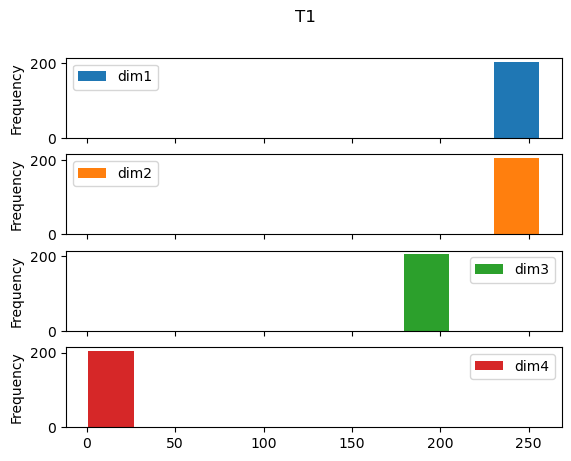

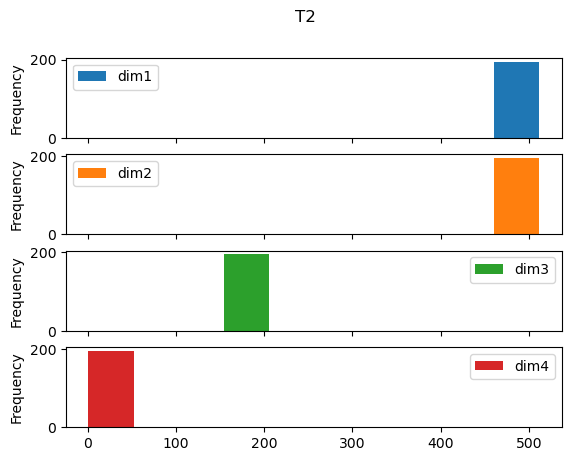

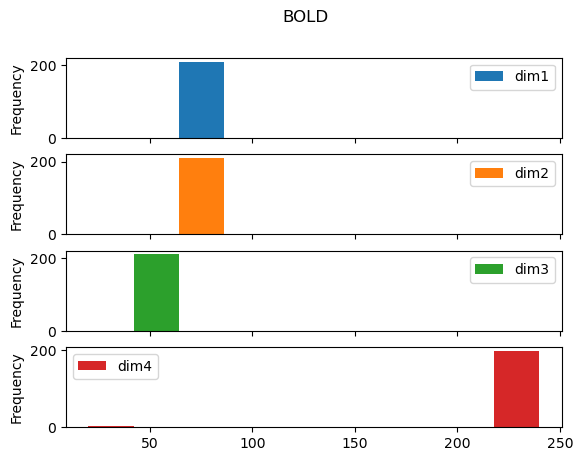

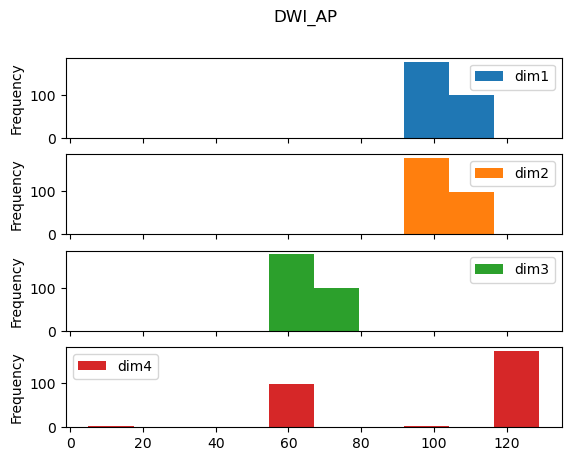

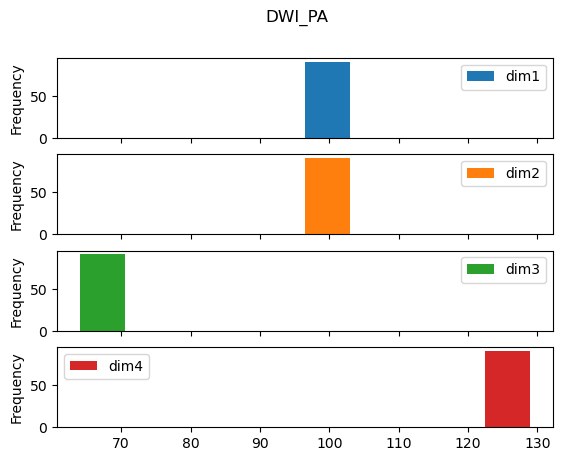

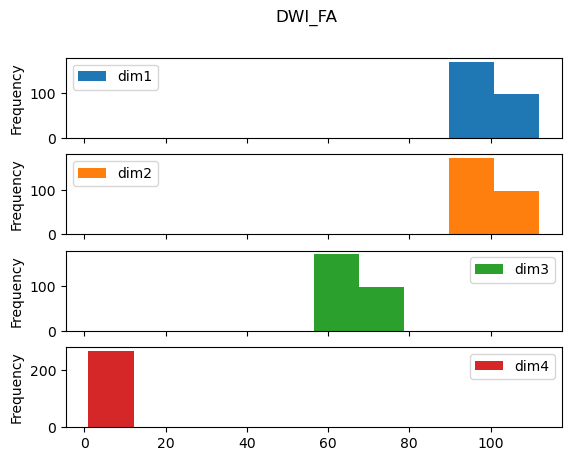

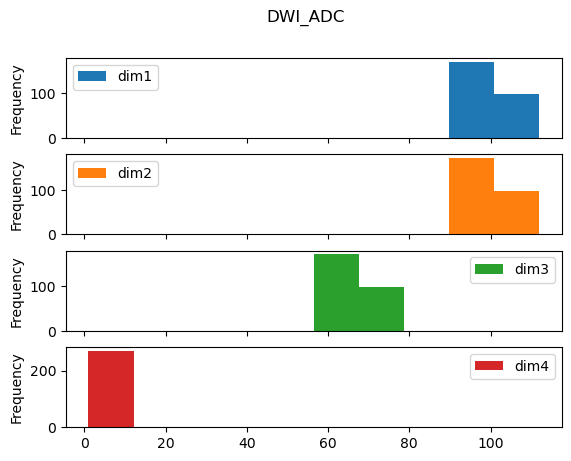

In [6]:
# Create and test heuristics
import seaborn as sns
def report_filt_res(dcm_df_, series_dict_):
    for series_name, series_list in series_dict_.items():
        series_df=dcm_df_[dcm_df_["series_description"].isin(series_list)]
        print(series_name, ':', len(series_df))
        series_df[["dim1", "dim2", "dim3", "dim4"]].plot(kind='hist', subplots=True,title=series_name)
report_filt_res(dcm_df, series_dict)

### Adding support for control group

In [7]:
dcm_control_info_path = repo_path / "workflow" / "HeuDiConv" / (dataset_name + "_control_dicomInfo.tsv")
dcm_control_df = pd.read_csv(dcm_control_info_path, sep="\t")
dcm_control_df=dcm_control_df[dicom_col_sel].copy()
dcm_control_df.patient_age=dcm_control_df.patient_age.apply(lambda x: int(x.split('Y')[0]))   # covnert age
list(dcm_control_df.series_description.unique())

['MB_ep2d_diff-DSI_2.0mmISO_AP',
 'MB_ep2d_diff-DSI_2.0mmISO_AP_SBRef',
 'MB_ep2d_diff-DTI_2.0mmISO_AP_ColFA',
 'cmrr_mbep2d_bold-rsfMRI-3mmISO',
 'MB_ep2d_diff-DSI_2.0mmISO_AP_ADC',
 'MB_ep2d_diff-DTI_2.0mmISO_AP_FA',
 'MB_ep2d_diff-DTI_2.0mmISO_AP_EXP',
 'MB_ep2d_diff-DSI_2.0mmISO_PA_ColFA',
 'MB_ep2d_diff-DSI_2.0mmISO_PA_FA',
 'MB_ep2d_diff-DSI_2.0mmISO_PA_TRACEW',
 'MB_ep2d_diff-DTI_2.0mmISO_AP_TRACEW',
 'MB_ep2d_diff-DTI_2.0mmISO_AP_ADC',
 'MB_ep2d_diff-DTI_2.0mmISO_AP',
 'MB_ep2d_diff-DTI_2.0mmISO_AP_SBRef',
 'MB_ep2d_diff-DSI_2.0mmISO_AP_ColFA',
 'MB_ep2d_diff-DSI_2.0mmISO_AP_FA',
 'MB_ep2d_diff-DSI_2.0mmISO_AP_TRACEW',
 'MB_ep2d_diff-DSI_2.0mmISO_PA_ADC',
 'MB_ep2d_diff-DSI_2.0mmISO_PA',
 'MPRAGE',
 'MB_ep2d_diff-DSI_2.0mmISO_PA_SBRef']

T1 : 128
BOLD : 119
DWI_AP : 148
DWI_PA : 68
DWI_FA : 147
DWI_ADC : 147


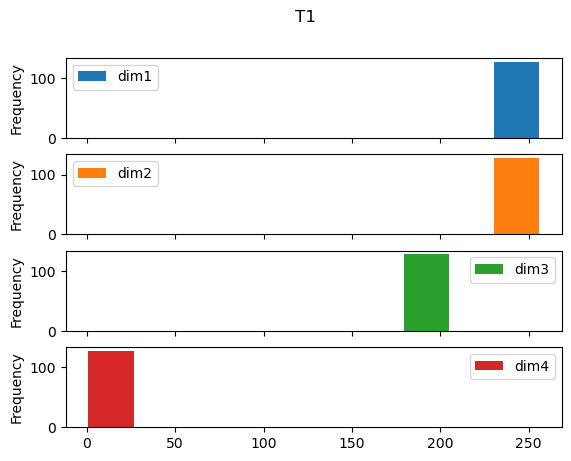

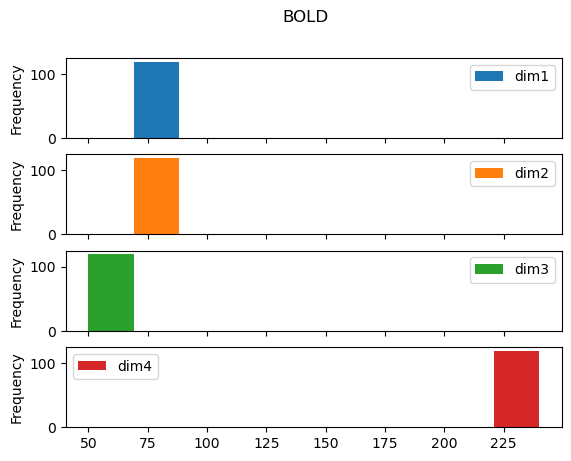

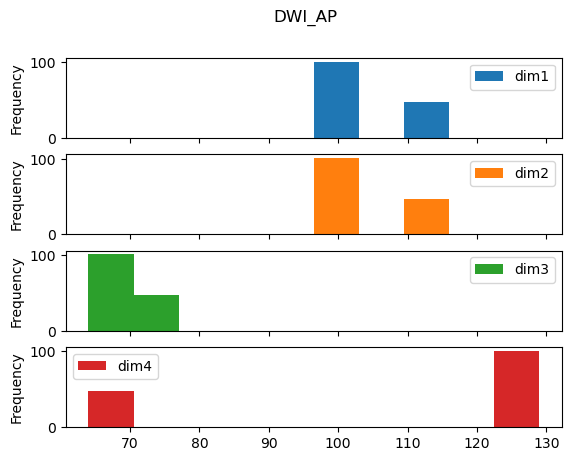

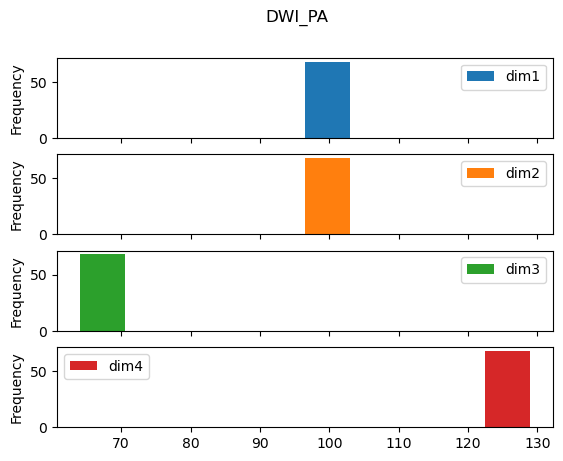

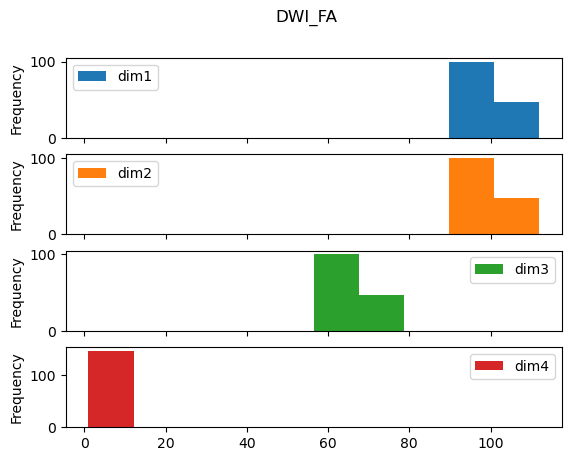

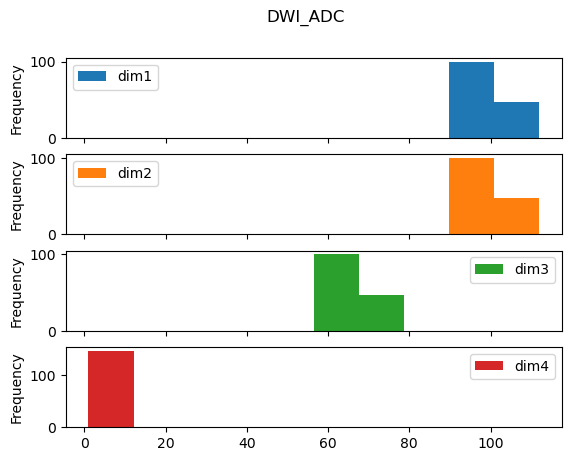

In [7]:
report_filt_res(dcm_control_df, series_dict)

## 2. Subject-visit csv files for fmriprep

In [59]:
import bids

from bids import BIDSLayout
print('pybids version:', bids.__version__)
import os
cwd_dir='/scratch' # CC
cwd_path = Path(cwd_dir)

ds_layout=BIDSLayout(bids_path)
bids_df = ds_layout.to_df()
fmriprep_dir = repo_path / 'workflow'/ 'fMRIPrep' 

pybids version: 0.15.1


In [60]:
save_file = 1
image_summary_info_path = repo_path / "workflow" / (dataset_name+"image_info.csv") 
subj_ses_list_path = repo_path / "workflow" / (dataset_name+"sub-ses.csv") 

print(list(bids_df.suffix.unique()))
bids_col_list = ['subject','session','suffix']
#print(', '.join(list(bids_df[(bids_df.suffix=="T1w") & (bids_df.extension==".nii.gz")].path)))
dwi_df=bids_df[(bids_df.suffix=="dwi") & (bids_df.extension==".nii.gz")].loc[:, bids_col_list]
t1_df=bids_df[(bids_df.suffix=="T1w") & (bids_df.extension==".nii.gz")].loc[:, bids_col_list]
bold_df=bids_df[bids_df.acquisition=="mbep2d"].loc[:, bids_col_list]# bug, _bold.nii.gz not in layout
bold_df.suffix="bold"
#bids_sum = pd.concat([t1_df,bold_df,dwi_df])
#bids_sum.pivot(index=["subject", "session"], columns=['suffix', 'acquisition'])
#t1_df.join(bold_df, on=["subject", "session"])
bids_sum=pd.merge(pd.merge(t1_df, bold_df, on =["subject", "session"], how='outer'), dwi_df, on =["subject", "session"], how='outer')

if save_file and len(bids_sum)<1000:
    bids_sum.to_csv(image_summary_info_path, index=False)
    for _ses in list(bids_sum.session.unique()):
        t1_df[t1_df.session==_ses].loc[:,["subject", "session"]].to_csv(repo_path / "workflow" / (dataset_name+"_ses-"+_ses+".csv") , index=False, header=False)
#

['description', 'participants', 'T1w', 'scans', 'dwi', 'bold', nan]


In [65]:
# By default visit=0
save_file=1

#subj_dicom_info_file = codes_path / 'workflow' / 'HeuDiConv' / 'MDD_PTSD_dicomInfo.tsv' # Information from download database.
participants_file = data / 'participants.tsv' # Information from download database.

subj_tab_file = fmriprep_dir / ('proj-'+dataset_name +'_subjVisit-list.csv')  # Information from download database.

participants_df = pd.read_csv(participants_file, sep='\t')
participants_df['visit']=0
participants_df=participants_df.drop(columns=['age', 'sex', 'group'])
if save_file and len(participants_df)<1000:
    participants_df.to_csv(subj_tab_file, index=False, header=False)
#else:
#    print("Exceed MAX JOB NUMBER of 1000!")    
participants_df

,participant_id,visit
0,sub-wangzhen01LIUXIAOQI4100120170920,0
1,sub-wangzhen01WANGYIKANG3102120170826,0
2,sub-wangzhen01ZHANGHE4097120170829,0
3,sub-wangzhen01CAOXIAOWU421320230612,0
4,sub-wangzhen01FANTIANQU4208120201116,0
...,...,...
197,sub-wangzhen01TAOSHANAN3098120170812,0
198,sub-wangzhen01ZHANGGEGE41065120170307,0
199,sub-wangzhen01LUXIN41072120170422,0
200,sub-wangzhen01ZOUWEI31073120170110,0


In [9]:
# For control subjects
# By default visit=0
save_file=1

fmriprep_dir = repo_path / 'workflow'/ 'fMRIPrep' 
#subj_dicom_info_file = codes_path / 'workflow' / 'HeuDiConv' / 'MDD_PTSD_dicomInfo.tsv' # Information from download database.
participants_file = Path(repo_path_str) / 'data' / 'participants_control.tsv' # Information from download database.

subj_tab_file = fmriprep_dir / (dataset_name +'_control_session-list.csv')  # Information from download database.

participants_df = pd.read_csv(participants_file, sep='\t')
participants_df['visit']=0
participants_df=participants_df.drop(columns=['age', 'sex', 'group'])
if save_file and len(participants_df)<1000:
    participants_df.to_csv(subj_tab_file, index=False, header=False)
#else:
#    print("Exceed MAX JOB NUMBER of 1000!")    
participants_df

,participant_id,visit
0,sub-WZOCD120591WANGBAO20160221,0
1,sub-wangzhen01WANGYU12125120170820,0
2,sub-wangzhen01YANGJIANQUAN12073120161030,0
3,sub-wangzhen01CHENGUILIN233120230321,0
4,sub-wangzhen01LIYANG12235120180818,0
...,...,...
125,sub-wangzhen01XUYI12113120170513,0
126,sub-wangzhen01LILIN12109120170513,0
127,sub-wangzhen01LIUJIE12105120170423,0
128,sub-wangzhen01TANGMINJIE12137120170924,0


## 3. Create bids-filter for all the sessions: 
mr_proc\workflow\fMRIPrep\anat_ses_\<session number\>.json

In [66]:
# Create BIDS filter files
save_file=1
output_dir = repo_path / "workflow" / "fMRIPrep"
visit_list = ["0"]

import json
basic_json_filename = 'func_ses-?.json'
#functional workflow
func_session_json_dict={
    "t1w": {
        "datatype": "anat",
        "session": "0",
	    "suffix": "T1w"
    },
    "bold": {
        "datatype": "func",
        "session": "0",
        "suffix": "bold"
    }
}
# anatomical workflow
anat_session_json_dict={
    "t1w": {
        "datatype": "anat",
        "session": "0",
	    "suffix": "T1w"
    }
}

# using function MRI workflow
for _x in visit_list:
    ses_str=str(_x)
    json_file_tmp = basic_json_filename.replace('?', ses_str)
    print("Creating bids filter for", json_file_tmp)
    func_session_json_dict['t1w']['session']=ses_str
    func_session_json_dict['bold']['session']=ses_str
    json_string_tmp = json.dumps(func_session_json_dict, indent=4)
    #print(json_string_tmp)
    if save_file==1:
        with open((output_dir/json_file_tmp), 'w', encoding='utf-8') as outfile_tmp:
            outfile_tmp.write(json_string_tmp)

Creating bids filter for func_ses-0.json


## 4. Rerun sdMRI fmriprep failure subjects
sdMRI_subject_session_rerun1.csv

In [ ]:
save_file=0

sdMRI_err_file = fmriprep_dir /'err_fmriprep_run1.log' # Information from download database.
sdMRI_rerun1_ses_file = fmriprep_dir / 'sdMRI_subject_session_rerun1.csv'  

subj_ses_col_names = ['subject', 'session']
sdMRI_rerun1_df = pd.read_csv(sdMRI_err_file, names=subj_ses_col_names, header=None, sep='_', usecols=[2,3])
sdMRI_rerun1_df = sdMRI_rerun1_df.drop_duplicates()

if save_file:
    sdMRI_rerun1_df.to_csv(sdMRI_rerun1_ses_file, index=False, header=False)
#sdMRI_rerun1_df

## 5. simple QC scripts
    1. Reference to the description of fMRIPrep docs [https://fmriprep.org/en/stable/outputs.html]
    2. test code for: mr_proc/workflow/fMRIPrep/fmriprep_simple_qc.py

In [ ]:
# libs and envs
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import os
import glob
import shutil

# inputs
root_str = "/scratch/PPMI_ses-21_fmriprep_anat_20.2.7"
out_report_dir = '/scratch' # CC
out_csv_dir = out_report_dir+'/mr_proc/workflow/fMRIPrep'

root_dir = Path(root_str)
fmriprep_dir = root_dir / "fmriprep"
fs_dir = root_dir / "freesurfer-6.0.1"

## general fMRIPrep info
root_folder = root_str.split('/')[-1]
[dataset_name, ses_full_str, software_name, proc_name, software_version]=root_folder.split('_')
# Session info
ses_name=ses_full_str.split('-')[-1]
fs_ver = str(fs_dir).split('/')[-1].split('-')[-1]

# qc report folder
report_folder_name=root_folder+"_report"
qc_report_out_dir = Path(out_report_dir+'/'+report_folder_name)
if (not qc_report_out_dir.is_dir()): os.mkdir(qc_report_out_dir) 
else: shutil.rmtree(qc_report_out_dir); os.mkdir(qc_report_out_dir) 
# qc summary table file
qc_tab_file = Path(out_csv_dir+'/'+root_folder+"_report.csv")

# get subject list
sub_withFolder=[x for x in next(os.walk(fmriprep_dir))[1] if "sub" in x]
sub_withReport=[x.split('.')[0] for x in next(os.walk(fmriprep_dir))[2] if x.split('.')[-1]=="html"]
sub_fsFolder=[x for x in next(os.walk(fs_dir))[1] if "sub" in x]
sub_list=list(set(sub_withFolder) or set(sub_reported) or set(sub_fsFolder))
n_sub=len(sub_list)
print(str(n_sub)+" fMRIPreped (version "+software_version+") subjects found for Dataset -> "+dataset_name+" Session -> "+ses_name)
# create qc summary df
qc_df = pd.DataFrame({'dataset':[dataset_name]*n_sub,'session':[ses_name]*n_sub,'fmriprep_proc':[proc_name]*n_sub,'fMRIPrep_ver':[software_version]*n_sub}, index=sub_list)
for x in sub_withFolder: qc_df.loc[x,'sub_fMRIPrep']=1
for x in sub_withReport: qc_df.loc[x,'sub_report']=1
for x in sub_fsFolder: qc_df.loc[x,'sub_Freesurfer']=1
for x in sub_fsFolder: qc_df.loc[x,'Freesurfer_ver']=fs_ver

#QC image list
fMRIPrep_qc_dict = {'t1_image': 'desc-preproc_T1w.nii.gz',
                    't1_mask' : 'desc-brain_mask.nii.gz',
                    'aparcaseg' : 'desc-aparcaseg_dseg.nii.gz',
                    'aseg': 'desc-aseg_dseg.nii.gz',
                    'dseg': 'dseg.nii.gz',
                    'prob_csf': 'label-CSF_probseg.nii.gz',
                    'prob_gm' : 'label-GM_probseg.nii.gz', 
                    'prob_wm' : 'label-WM_probseg.nii.gz',
                    'mni_T1'  : 'space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w.nii.gz',
                    'mni_mask': 'space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz', 
                    'mni_dseg': 'space-MNI152NLin2009cAsym_res-2_dseg.nii.gz',
                    'mni_csf' : 'space-MNI152NLin2009cAsym_res-2_label-CSF_probseg.nii.gz',
                    'mni_gm'  : 'space-MNI152NLin2009cAsym_res-2_label-GM_probseg.nii.gz', 
                    'mni_wm'  : 'space-MNI152NLin2009cAsym_res-2_label-WM_probseg.nii.gz'
                   }
Freesurfer_qc_dict = {'fs_aseg'  : 'aseg.stats',
                      'fs_wmparc':'wmparc.stats',
                      # left hemisphere
                      'lh.a2009s' : 'lh.aparc.a2009s.stats',
                      'lh.DKT'    : 'lh.aparc.DKTatlas.stats',
                      'lh.pial'   : 'lh.aparc.pial.stats',
                      'lh.aparc'  : 'lh.aparc.stats',
                      'lh.BA_exvivo': 'lh.BA_exvivo.stats',
                      'lh.BA_exvivo_th' : 'lh.BA_exvivo.thresh.stats', 
                      'lh.curv' : 'lh.curv.stats',
                      'lh.w-g.pct' : 'lh.w-g.pct.stats',
                      # right hemisphere
                      'rh.a2009s': 'rh.aparc.a2009s.stats', 
                      'rh.DKT'   : 'rh.aparc.DKTatlas.stats',
                      'rh.pial'  : 'rh.aparc.pial.stats',
                      'rh.aparc' : 'rh.aparc.stats',
                      'rh.BA_exvivo' : 'rh.BA_exvivo.stats',
                      'rh.BA_exvivo_th' : 'rh.BA_exvivo.thresh.stats', 
                      'rh.curv' : 'rh.curv.stats',
                      'rh.w-g.pct' : 'rh.w-g.pct.stats'
                     }
# set run
current_run_str = '_run-1_';
for sub_id_str in sub_list:
    # copy out fMRIPrep report
        if (fmriprep_dir/sub_id_str).is_dir():
            qc_df.loc[sub_id_str, 'sub_fMRIPrep']=int(1)
            if (fmriprep_dir/sub_id_str/"figures").is_dir():
                shutil.copytree(fmriprep_dir/sub_id_str/"figures", qc_report_out_dir/sub_id_str/"figures", dirs_exist_ok=True)
            if (fmriprep_dir/sub_id_str/"log").is_dir():
                shutil.copytree(fmriprep_dir/sub_id_str/"log", qc_report_out_dir/sub_id_str/"log", dirs_exist_ok=True)
        else:
            qc_df.loc[sub_id_str, 'sub_fMRIPrep']=int(0)
        # html file
        if (fmriprep_dir/(sub_id_str+'.html')).is_file():
            qc_df.loc[sub_id_str, 'sub_report']=int(1)
            shutil.copy2(fmriprep_dir/(sub_id_str+'.html'), qc_report_out_dir/(sub_id_str+'.html'))
        else:
            qc_df.loc[sub_id_str, 'sub_report']=int(0)
    ## qc fmriprep
    sub_img_dir = fmriprep_dir/sub_id_str/ses_full_str/'anat'
    
    for k, v in fMRIPrep_qc_dict.items():
        current_fmriprep_file_name = sub_id_str+'_'+ses_full_str+current_run_str+v
        current_fmriprep_file = sub_img_dir/current_fmriprep_file_name
        if current_fmriprep_file.is_file():
            qc_df.loc[sub_id_str, k]=int(1)
        else:
            qc_df.loc[sub_id_str, k]=int(0)
            print(sub_id_str+' missing fMRIPrep results: '+current_fmriprep_file_name)
    ## qc freesurfer
    sub_fs_dir = fs_dir/sub_id_str/'stats'
    for k, v in Freesurfer_qc_dict.items():
        #print(str(sub_img_dir/(sub_id_str+'_'+ses_full_str+current_run_str+v)))
        current_fmriprep_file = sub_fs_dir/v
        if current_fmriprep_file.is_file():
            qc_df.loc[sub_id_str, k]=int(1)
        else:
            qc_df.loc[sub_id_str, k]=int(0)
            print(sub_id_str+' missing Freesurfer results: '+v)
            
## retrieve qc reports
# zip fMRIPrep QC report
shutil.make_archive(out_report_dir+'/'+report_folder_name, 'zip', str(qc_report_out_dir))
# save QC report
qc_df.loc[:, 'fmriprep_rerun']=qc_df.loc[:,fMRIPrep_qc_dict.keys()].apply(lambda x: int(not all(x)), axis=1)
qc_df.loc[:, 'freesurfer_rerun']=qc_df.loc[:,Freesurfer_qc_dict.keys()].apply(lambda x: int(not all(x)), axis=1)
ordered_columns = ['dataset', 'session', 'fmriprep_proc', 'fMRIPrep_ver', 'sub_fMRIPrep',
                   'sub_report', 'sub_Freesurfer', 'Freesurfer_ver', 'fmriprep_rerun', 'freesurfer_rerun', 
                   't1_image', 't1_mask','aparcaseg', 'aseg', 'dseg', 'prob_csf', 'prob_gm', 'prob_wm', 
                   'mni_T1', 'mni_mask', 'mni_dseg', 'mni_csf', 'mni_gm', 'mni_wm', 
                   'fs_aseg', 'fs_wmparc',
                   'lh.a2009s', 'lh.DKT', 'lh.pial', 'lh.aparc', 'lh.BA_exvivo', 'lh.BA_exvivo_th', 'lh.curv', 'lh.w-g.pct', 
                   'rh.a2009s', 'rh.DKT', 'rh.pial', 'rh.aparc', 'rh.BA_exvivo', 'rh.BA_exvivo_th', 'rh.curv', 'rh.w-g.pct']
qc_df=qc_df[ordered_columns]
rerun_list=qc_df[(qc_df['fmriprep_rerun']==1)|(qc_df['freesurfer_rerun']==1)].index
if len(rerun_list)==0:
    print(root_folder, " passed simple QC!")
else:
    print('Subjects need to rerun for',root_folder, ':',rerun_list)
qc_df.to_csv(qc_tab_file)
qc_df

## 6. Create rerun sub-session list after simple QC scripts
    1. Input:  The simple fMRIPrep QC results for all sessions;
    2. Output: The sub-ses csv rerun_list; 

In [ ]:
# Generate rerun2 list based on the qc results from fmriprep_simple_qc.py in mr_proc/meta
# libs and envs
save_file=1
import sys
import pandas as pd

# inputs
qc_res_dir = '/scratch/mr_proc/workflow/fMRIPrep'

# output
sub_ses_rerun2_file = '/scratch/mr_proc/workflow/fMRIPrep/sdMRI_subject_session_rerun2.csv'

ses_list = ['0', '1', '5', '7', '9', '11', '21', '30', '90', '91'];
ses_df = [pd.read_csv(qc_res_dir+'/PPMI_ses-'+x+'_fmriprep_anat_20.2.7_report.csv')for x in ses_list]
rerun2_df = pd.concat(ses_df)
rerun2_df=rerun2_df[(rerun2_df['fmriprep_rerun']==1)|(rerun2_df['Freesurfer_ver']==1)].copy()
sdMRI_rerun2_df=rerun2_df[['Unnamed: 0','session']]
sdMRI_rerun2_df.columns=['subject', 'session']

if save_file:
    sdMRI_rerun2_df.to_csv(sub_ses_rerun2_file, index=False, header=False)
sdMRI_rerun2_df